In [1]:
### Imports
%load_ext autoreload
%autoreload 2

# Append main folder
import sys
sys.path.append("../")

import pykep as pk
import numpy as np
import matplotlib.pyplot as plt
import math

starting_t = pk.epoch_from_string('2022-01-01 00:00:00.000')
lower_cutoff_in_km = 6371 + 200 # Earth radius + ...
higher_cutoff_in_km = 6371 + 2000
planet_list = []
shell_list = []
xparams_list = []

## Read TLE data

In [23]:
#planet_list = pykep.util.read_tle("../data/tle.txt")
#satcat = pykep.util.read_satcat("../data/satcat.txt")
print("Loaded ",len(planet_list)," planets.")

Loaded  7178  planets.


# Reset planet_list and other

In [112]:
planet_list = []
shell_list = []
xparams_list = []
print("Planet list is now empty")

Planet list is now empty


# Generate partial constellations by specifying shell = ( altitude, inclination, nPlanes, nSats )

In [5]:
# creates a temporary shell that has to be appended to planet_list in cell "Append to planet_list and other"
# to be stored and not get overwritten (also concerning additional shell data shell_list, xparams_list)

#---input-----
altitude = 440
inclination = 50.0
nPlanes = 8
nSats = 11
#--------------
#-extra-params-
offsetM = 0                            #default 0  ; = offset for M added after each plane
startingM = 0                          #default 0  ; = offset for M that is not accumulating

startingW = 0#(360.0/32.0)/2.0           #default 0  ; = offset for W that is not accumulating
minimumW = 0                           #default 0  ; = orbital planes are distributed evenly
maximumW = 360.0                       #default 360    within range [minimumW,maximumW)
#--------------
minW = minimumW + startingW
maxW = maximumW + startingW

a = altitude*1000 + 6371000            # in [m], earth radius included
e = 0
i = inclination * pk.DEG2RAD
W = pk.DEG2RAD*minW
w = 0
M = pk.DEG2RAD * startingM

count=0

when = starting_t
mu_central_body = pk.MU_EARTH
mu_self = 1
radius = 1
safe_radius = 1

pStep = pk.DEG2RAD*(maxW-minW)/ nPlanes  # W goes from minimumW to maximumW (default: 0° to 360°)
sStep = 2*math.pi/ nSats                    # M goes from 0° to 360°
sExtraStep = pk.DEG2RAD*offsetM

planet_list_tmp = []
for x in range(nPlanes):
    for y in range(nSats):
        planet_list_tmp.append(pk.planet.keplerian(when,[a,e,i,W,w,M], mu_central_body, mu_self,radius, safe_radius ,"sat"))
        M = M + sStep
    count = count + 1
    W = W + pStep
    M = startingM + count*sExtraStep     #equals 0 + count*0 = 0 in the usual case
    
shell = (altitude,inclination,nPlanes,nSats)
xparams = (offsetM,startingM,startingW,minimumW,maximumW)

print("Added " + str(len(planet_list_tmp)) + " planets")

Added 88 planets


## Append to planet_list and other

In [6]:
# stores and appends temporary shell in planet_list (including lists with additional data)
planet_list = planet_list + planet_list_tmp
shell_list.append(shell)
xparams_list.append(xparams)
print("Added " + str(len(planet_list_tmp)) + " to planet_list now totalling " + str(len(planet_list)) + " planets.")

Added 88 to planet_list now totalling 288 planets.


## Plot some examples

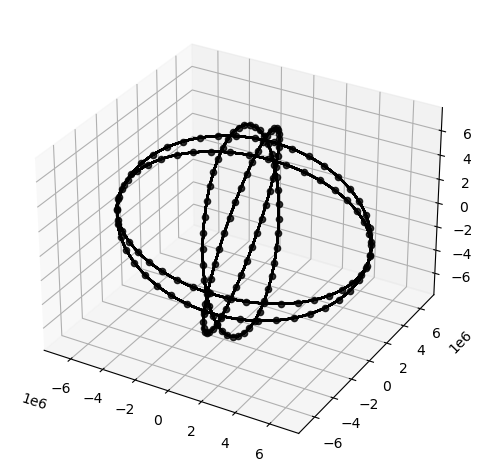

In [30]:
fig = plt.figure(figsize=(6,6),dpi=100)
ax = plt.axes(projection='3d')
for i in range (nPlanes*nSats):
    pk.orbit_plots.plot_planet(planet_list_tmp[i],axes=ax,s=20)

## Propagate all objects to t and discard too low and high ones

In [7]:
objects = []
count_too_low = 0
count_too_high = 0
for planet in planet_list:
    try:
        pos,v = planet.eph(starting_t)
        
        # convert to km and numpy
        pos = np.asarray(pos) / 1000.0 
        v = np.asarray(v) / 1000.0
        altitude = np.linalg.norm(pos)
        if altitude < lower_cutoff_in_km:
            count_too_low += 1
            continue
        if altitude > higher_cutoff_in_km:
            count_too_high += 1
            continue
        
        objects.append((pos,v))
    except RuntimeError as e:
        print(e, " propagating ",planet.name)
        
print("Successfully propagated ",len(objects)," objects.")
print(count_too_low," had a too small altitude")
print(count_too_high," had a too high altitude")

shells = ""
for i in range(len(shell_list)):
    for j in range(4):
        shells += str(shell_list[i][j]) + " "
    shells += "\n"
    
extraParams = ""
for i in range(len(xparams_list)):
    for j in range(5):
        extraParams += str(xparams_list[i][j]) + " "
    extraParams += "\n"

Successfully propagated  288  objects.
0  had a too small altitude
0  had a too high altitude


## Plot and store results

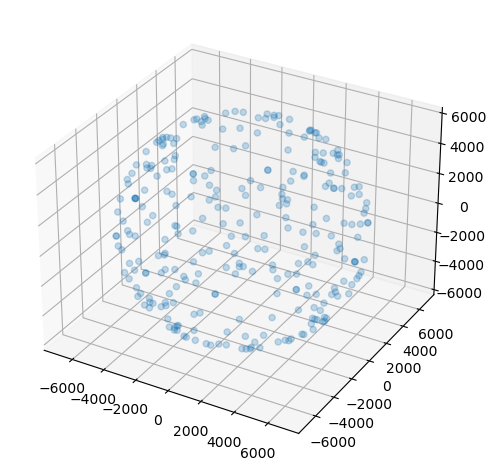

In [8]:
fig = plt.figure(figsize=(6,6),dpi=100)
ax = plt.axes(projection='3d');

positions = np.array([pos for pos,_ in objects])
velocities = np.array([v for _,v in objects])
ax.scatter(positions[:,0],positions[:,1],positions[:,2],".",alpha=0.25)

In [30]:
np.savetxt("../data/pos.csv",positions,delimiter=",")
np.savetxt("../data/v.csv",velocities,delimiter=",")

In [10]:
# assumes an existing directory with named as the constellation_name value and stores output there

constellation_name = "TestCon"


np.savetxt("../../data/" + constellation_name + "/pos.csv",positions,delimiter=",")
np.savetxt("../../data/" + constellation_name + "/v.csv",velocities,delimiter=",")

f1 = open("../../data/" + constellation_name + "/shells.txt","w")
f1.write(shells)
f1.close()

f2 = open("../../data/" + constellation_name + "/xparams.txt","w")
f2.write(extraParams)
f2.close()